In [267]:
import pandas as pd
import io
import zipfile
import requests
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 500)

# Price per Square Foot Calculation

In order to visualize the average price per square foot for residential buildings, we will use the PLUTO dataset.

 "PLUTO: Extensive land use and geographic data at the tax lot level in comma–separated values (CSV) file format. The PLUTO files contain more than seventy fields derived from data maintained by city agencies." https://www.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page

 **Each record is a tax lot**

### Method to calculate

`Price per square foot = AssessTot / (ResidFAR * ResArea)`

Where FAR is the maximum allowable residential FAR for the building, AssessTot is the assessed total value of the building, and Lot Area is the total area of the lot on which the building is located.

Floor Area Ratio (FAR) is a mathematical formula that determines how many square feet can be developed on a property in proportion to the lot area. 

Since this case study is focused on residential rent prices, we will use the ResidFAR datapoint provided.

Data definitions: https://s-media.nyc.gov/agencies/dcp/assets/files/pdf/data-tools/bytes/PLUTODD.pdf?v=22v3

#### ASSESSED TOTAL VALUE (AssessTot)

Data Source: Department of Finance - Property Tax System (PTS)
Description: The assessed total value for the tax lot.
The Department of Finance (DOF) calculates the assessed value by multiplying the
tax lot’s estimated full market value by a uniform percentage for the property’s tax
class.
DOF values properties based on current and constructive use, rather than legal use. The
predominant active use, which determines the classification of a property, is determined
by square footage. If the second story of a three-story building is mixed-use, an interior
inspection may be necessary to establish the commercial percentage of that story before
reclassification. In other cases, a two-story building with retail on the first floor may
have a sign identifying a second story accounting office. If, for example, the second
story is a primary residence and there is a difference in square footage from the first to
second floor, the mere presence of a business sign does not confirm a predominant
commercial use.

Additional research is required to ensure proper classification. This can include an
internal inspection, speaking to someone at the location or a neighbor, and researching
various records (such as filed Real Property Income and Expenses statements) from
DOF or other city agencies.

NYC Property Tax Classes are determined by NYS and described under Real
Property Tax Law (RPTL) Article §18-02 which mentions primary use for real
property classification.
Property value is assessed as of January 5th. If a new building is not completed by
April 14th, the assessed building value is 0 and the Building Class reverts to Vacant.
Assessed and exempt values are updated twice a year. Tentative values are released in
mid-January and final values are released around May 25. If the date on source file
(PTS), as reported in the Readme file, is between January 15 and May 25,
ASSESSED TOTAL VALUE is from the tentative roll for the tax year starting in
July. Otherwise, ASSESSED TOTAL VALUE is from the final roll


#### MAXIMUM ALLOWABLE RESIDENTIAL FAR (ResidFAR)

Data Source: Department of City Planning Zoning Division
Description: The maximum allowable residential floor area ratio, based on the zoning district
classification occupying the greatest percentage of the tax lot’s area as reported in
ZoneDist1. If the lot is assigned to more than one zoning district and ZoneDist1 does
not allow residential uses, MAXIMUM ALLOWABLE RESIDENTIAL FAR is
based on ZoneDist2, ZoneDist3 or ZoneDist4, in that order.
The maximum allowable residential floor area ratios are exclusive of bonuses for
plazas, plaza-connected open areas, arcades, or other amenities.
For R2X, R3, R4, and C3 zoning districts, ResidFAR does not include the attic
allowance, under which the FAR may be increased by up to 20% for the inclusion of
space beneath a pitched roof.
For properties zoned R6, R7, R7-1, R8 or R9, ResidFAR reflects the maximum
achievable floor area under ideal conditions.

The maximum allowable floor area does not reflect Voluntary Inclusionary Housing
or Mandatory Inclusionary Housing Program floor area. See Appendix F and Section
23-154, paragraphs (b) and (d) of the Zoning Resolution.
For properties in special mixed use districts, PLUTO uses the wide street maximum
allowable floor area ratio. Since the maximum allowable floor area ratio in mixed use
special districts is actually determined by whether the property is located on a wide
street or a narrow street, users should consult Section 23-153 of the Zoning
Resolution. 


#### RESIDENTIAL FLOOR AREA (ResArea)

Data Source: Department of Finance – Property Tax System (PTS)
Department of Finance - Mass Appraisal System (CAMA)
Description: An estimate of the exterior dimensions of the portion of the structure(s) allocated for
residential use.
Value is taken from PTS, if available. Otherwise it comes from CAMA.
For condominiums, RESIDENTIAL FLOOR AREA is the sum of the residential floor
area for condominium lots with the same billing lot. RESIDENTIAL FLOOR AREA
does not contain the condominium’s common area.

A RESIDENTIAL FLOOR AREA of zero can mean it is either not available or not
applicable.
An update to the floor area is triggered by the issuance of a Department of Buildings
permit, feedback from the public, or site visits by Department of Finance assessors.
The sum of the various floor area fields does not always equal TOTAL BUILDING
FLOOR AREA.



In [3]:
# URL of the PLUTO zip file online
url = "https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/nyc_pluto_22v3_csv.zip"

# Get the zip file
response = requests.get(url)

# Open the zip file
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

In [5]:
# using 2022 data
print(zip_file.namelist())

['pluto_22v3.csv']


In [208]:
# Extract the CSV file from the zip file
csv_file = zip_file.open("pluto_22v3.csv")


In [209]:
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(csv_file, low_memory=False)

In [315]:
df.head()

,borough,block,lot,cd,bct2020,bctcb2020,ct2010,cb2010,schooldist,council,zipcode,firecomp,policeprct,healthcenterdistrict,healtharea,sanitboro,sanitdistrict,sanitsub,address,zonedist1,zonedist2,zonedist3,zonedist4,overlay1,overlay2,spdist1,spdist2,spdist3,ltdheight,splitzone,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,areasource,numbldgs,numfloors,unitsres,unitstotal,lotfront,lotdepth,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,zonemap,zmcode,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
0,MN,574,65,102.0,1006300.0,1.006300e+10,63.0,2001.0,2.0,3.0,10011.0,E033,6.0,15.0,5700.0,1.0,2.0,3A,41 WEST 10 STREET,R6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,C6,2.0,0.0,NaN,UNAVAILABLE OWNER,2321.0,6540.0,0.0,6540.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,4.0,5.0,5.0,24.5,94.75,25.0,80.00,E,3.0,N,5.0,1.0,567000.0,2223000.0,0.0,1839.0,1989.0,0.0,Greenwich Village Historic District,NaN,2.82,2.43,0.0,4.8,1,1.005740e+09,NaN,63.0,984990.0,206856.0,12c,NaN,103 019,10207.0,NaN,NaN,NaN,1,NaN,NaN,22v3,t,40.734448,-73.997330,NaN
1,BK,3435,45,304.0,3041100.0,3.041100e+10,411.0,1000.0,32.0,37.0,11207.0,Q252,83.0,34.0,3500.0,3.0,4.0,3B,177 COOPER STREET,R6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,B2,1.0,0.0,NaN,"WASHINGTON, TIFFANIE L",2000.0,1800.0,0.0,1800.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,20.0,100.00,20.0,45.00,N,3.0,N,5.0,2.0,12300.0,74940.0,1460.0,1901.0,0.0,0.0,NaN,NaN,0.90,2.43,0.0,4.8,3,3.034350e+09,NaN,411.0,1010129.0,190246.0,17c,NaN,309 021,31109.0,NaN,NaN,NaN,1,NaN,NaN,22v3,NaN,40.688820,-73.906684,NaN
2,BK,3447,29,304.0,3041100.0,3.041100e+10,411.0,1002.0,32.0,37.0,11207.0,Q252,83.0,34.0,3500.0,3.0,4.0,3B,222 MOFFAT STREET,M1-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,B1,1.0,0.0,NaN,JDC HOME INC.,2000.0,2200.0,0.0,2200.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,20.0,100.00,20.0,55.00,N,3.0,N,5.0,2.0,11940.0,75780.0,0.0,1910.0,0.0,0.0,NaN,NaN,1.10,0.00,1.0,2.4,3,3.034470e+09,NaN,411.0,1010530.0,190085.0,17c,NaN,309 021,31109.0,NaN,NaN,NaN,1,NaN,NaN,22v3,NaN,40.688377,-73.905239,NaN
3,BX,2514,10,204.0,2019300.0,2.019300e+10,193.0,4001.0,9.0,8.0,10452.0,E068,44.0,23.0,3310.0,2.0,4.0,2A,1082 OGDEN AVENUE,R7-1,NaN,NaN,NaN,C1-4,NaN,NaN,NaN,NaN,NaN,N,A1,1.0,0.0,NaN,"PINEDA, ARELIS",2875.0,1710.0,0.0,1710.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,1.0,1.0,25.0,115.00,19.0,42.67,N,1.0,N,5.0,2.0,14340.0,34560.0,0.0,1899.0,0.0,0.0,NaN,NaN,0.59,3.44,0.0,4.8,2,2.025140e+09,NaN,193.0,1004213.0,243491.0,3b,NaN,210S041,20908.0,NaN,NaN,NaN,1,NaN,NaN,22v3,NaN,40.834979,-73.927858,NaN
4,MN,482,7501,102.0,1004500.0,1.004500e+10,45.0,1006.0,2.0,1.0,10013.0,E055,5.0,15.0,6800.0,1.0,2.0,1A,406 BROOME STREET,C6-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,RB,5.0,0.0,NaN,LAFAYETTE COMMERCL CONDO,11750.0,74349.0,74349.0,0.0,9849.0,64500.0,0.0,0.0,0.0,0.0,2.0,1.0,7.0,0.0,25.0,149.5,100.42,0.0,0.00,NaN,0.0,Y,5.0,5.0,1143002.0,6811650.0,0.0,1900.0,0.0,0.0,SoHo-Cast Iron Historic District Extension,NaN,6.33,6.02,6.0,6.5,1,1.004828e+09,463.0,45.0,984876.0,202030.0,12c,NaN,101N073,10206.0,E-130,1.004821e+09,08/25/1988,1,NaN,NaN,22v3,NaN,40.721202,-73.997742,NaN


In [210]:
df.shape

(858619, 92)

In [211]:
df.borough.value_counts()

QN    324591
BK    276561
SI    125167
BX     89605
MN     42695
Name: borough, dtype: int64

Many different boundary options to consider: 

By CD is likely most ideal, will depend how the income data is cross referenced for this layer.

# Filter by Building Class

Our objective is to analyze residential properties, therefore we use the building class variable and manually reveiwed the building class that is considered as residential, such as including condos, one-house, even the single mobile home in the NYC 5 boroughs. We exclude non-residential building classes such as warehouses, or condos that are for commercial use without any residential (mixed use is considered as residential)

We want to only quantify residential area. Let's check to make sure the resarea can serve that purpose, and no additional filtering is required before we aggregate by CB.

Can cannot just use the zonedist1 if begins with R. Or units residential > 0. Since there were many inconsistencies elsewhere found that could skew averages. This led me us to use the building class of each tax lot instead. 

A code describing the major use of structures on the tax lot.
Except as described below, BUILDING CLASS is taken from PTS without
modification.

R only captures for condominiums, will need to also add others based on: https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html


For condominiums, PTS contains the building class for each unit lot. When merging
this data into a single record for the billing lot, DCP creates several mixed-use
building classes (RC, RD, RI, RM, RX, and RZ). These are assigned as follows:
• If all unit lots have the same building class, that building class is used for the
billing lot.
• PTS building class types are grouped as follows:
o Commercial - R5, R7, R8, RA, RB, RH, and RK
o Residential - R1, R2, R3, R4, R6, and RR
o Mixed commercial and residential – R9
o Industrial/warehouse - RW
PLUTO DATA DICTIONARY November 2019 (19v2)
16
• If the unit lots are a mixture of commercial building types, BUILDING
CLASS = RC.
• If the unit lots are a mixture of residential building types, BUILDING
CLASS = RD.
• If the unit lots are a mixture of commercial and residential building types,
BUILDING CLASS = RM.
• If the unit lots are a mixture of commercial and industrial/warehouse building
types, BUILDING CLASS = RI.
• If the unit lots are a mixture of commercial, residential, and
industrial/warehouse building types, BUILDING CLASS = RX.
• If the unit lots are a mixture of residential and industrial/warehouse building
types, BUILDING CLASS = RZ.
• When unit lots with a building class of RG (Indoor Parking), RP (Outdoor
Parking), RS (Non-Business Storage Space), or RT
(Terraces/Gardens/Cabanas) have the same billing lot as another building
class, their building class is ignored. For example, if the billing lot has unit
lots with a building class of R4 (Residential Unit in Elevator Bldg) and RG
(Indoor Parking), BUILDING CLASS = R4.
Q0 is assigned by DCP to tax lots with an PTS building class starting with “V” that
are identified in the NYC GIS Zoning Database as PARK, BALL FIELD,
PLAYGROUND, or PUBLIC SPACE.
PTS contains two building classes for some tax lots, with one of the building classes
being Z7 (Easement). BUILDING CLASS is only set to Z7 when it is the only PTS
building class for the tax lot.
See Appendix C - Building Class Codes for valid values 

In [212]:
# all building class types in PLUTO dataset
df['bldgclass'].unique()

array(['C6', 'B2', 'B1', 'A1', 'RB', 'R4', 'C0', 'S5', 'Z9', 'C2', 'V1',
       'S1', 'D8', 'RM', 'C1', 'A9', 'S9', 'H3', 'R3', 'G7', 'C3', 'R1',
       'C5', 'B9', 'A5', 'A4', 'B3', 'C4', 'K4', 'V0', 'S2', 'S4', 'S3',
       'K2', 'M1', 'D6', 'D0', 'HS', 'G0', 'C7', 'D4', 'O4', 'R6', 'M9',
       'K1', 'G1', 'A2', 'D1', 'H1', 'W8', 'O3', 'A3', 'W4', 'H2', 'Z7',
       'D3', 'D7', 'E1', 'RC', 'G2', 'J3', 'QG', 'E9', 'Q1', 'R2', 'F4',
       'U6', 'M4', 'A7', 'F5', 'D9', 'Q2', 'I6', 'A8', 'O7', 'O5', 'K9',
       'U0', 'W6', nan, 'Z0', 'I9', 'F9', 'I5', 'S0', 'A0', 'J5', 'V9',
       'R5', 'O6', 'Z8', 'RD', 'W3', 'M3', 'G4', 'D5', 'Q7', 'W2', 'O9',
       'RK', 'O1', 'G9', 'E2', 'Q0', 'W7', 'N4', 'O8', 'W9', 'O2', 'K5',
       'RA', 'P5', 'M2', 'J4', 'C9', 'A6', 'V3', 'P7', 'U7', 'I7', 'E7',
       'Q9', 'P9', 'Z4', 'H6', 'Y4', 'N9', 'U9', 'J1', 'Y2', 'Q8', 'F1',
       'V8', 'T2', 'N2', 'HR', 'G6', 'V2', 'D2', 'Z3', 'G5', 'H5', 'J9',
       'RI', 'K7', 'H8', 'W5', 'P3', 'HB', 'RH', 'W1

### Manual Review 

Left some of the more building classification types that surprised me to see. Looked into if they should be included as residential, used area vs. total to compare with other housing types that are definitely residential.

In [115]:
# cape cod was interesting to see - confirmed as residential
df[df['bldgclass'] == 'A0'].borough.value_counts()

QN    7494
SI    1071
BK      31
BX      26
Name: borough, dtype: int64

“A0” is a Cape Cod style one family home

In [127]:
# MOBILE HOMES/TRAILER PARKS was interesting to see - there is only 1!
df[df['bldgclass'] == 'CM'].borough.value_counts()

SI    1
Name: borough, dtype: int64

In [128]:
df[df['bldgclass'] == 'CM']

,borough,block,lot,cd,bct2020,bctcb2020,ct2010,cb2010,schooldist,council,zipcode,firecomp,policeprct,healthcenterdistrict,healtharea,sanitboro,sanitdistrict,sanitsub,address,zonedist1,zonedist2,zonedist3,zonedist4,overlay1,overlay2,spdist1,spdist2,spdist3,ltdheight,splitzone,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,areasource,numbldgs,numfloors,unitsres,unitstotal,lotfront,lotdepth,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,zonemap,zmcode,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
494267,SI,1392,2,501.0,5032300.0,5.032300e+10,323.0,1012.0,31.0,49.0,10303.0,E158,121.0,51.0,100.0,5.0,1.0,4C,2701 GOETHALS ROAD NORTH,M2-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,CM,2.0,0.0,NaN,SEVENTH GARDEN PARK L,354000.0,115200.0,0.0,115200.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,130.0,1.0,128.0,128.0,738.0,625.0,15.0,60.0,N,0.0,Y,5.0,0.0,637200.0,1483200.0,0.0,1984.0,0.0,0.0,NaN,NaN,0.33,0.0,2.0,0.0,5,5.013920e+09,NaN,323.0,934558.0,168016.0,20a,Y,502 273,50603.0,NaN,NaN,NaN,1,NaN,1.0,22v3,NaN,40.627702,-74.179018,NaN


In [134]:
# vacant residential land, not manhattan
df[df['bldgclass'] == 'V0'].borough.value_counts()

QN    6307
SI    5784
BK    3816
BX    2991
Name: borough, dtype: int64

In [139]:
# evidence to exclude, since there are no actual residential units available, therefore price per square foot doesn't really make sense
df[df['bldgclass'] == 'V0'].unitsres.describe()

count    18898.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: unitsres, dtype: float64

Text(0, 0.5, 'total value for the tax lot ($)')

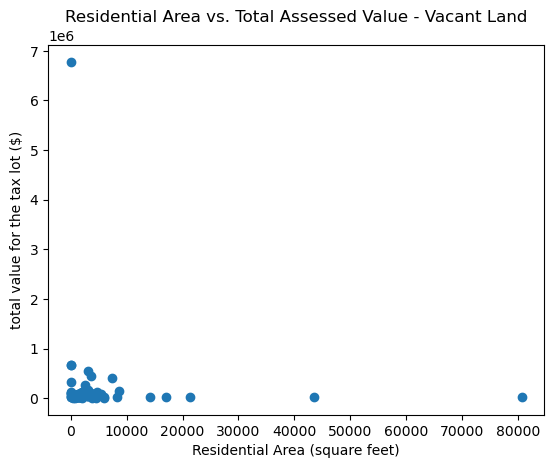

In [262]:
# look into area vs. value assessed
plt.scatter(df[df['bldgclass'] == 'V0'].resarea, df[df['bldgclass'] == 'V0'].assesstot)
plt.title('Residential Area vs. Total Assessed Value - Vacant Land')
plt.xlabel('Residential Area (square feet)')
plt.ylabel('total value for the tax lot ($)')

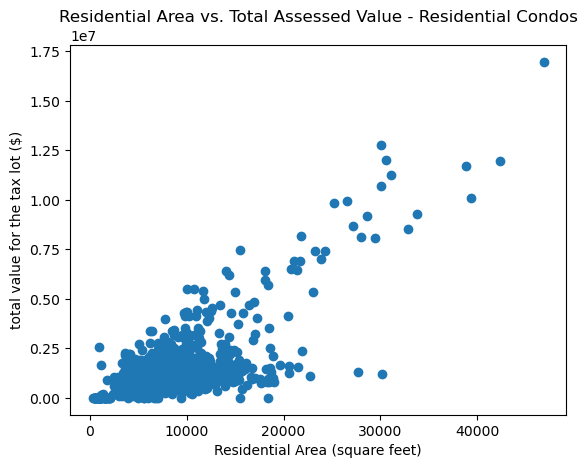

In [261]:
plt.title('Residential Area vs. Total Assessed Value - Residential Condos')
plt.xlabel('Residential Area (square feet)')
plt.ylabel('total value for the tax lot ($)')
plt.scatter(df[df['bldgclass'] == 'R1'].resarea, df[df['bldgclass'] == 'R1'].assesstot)

Compared to the residential condos the vacant land has many outliers - mainly on the assesstot value.

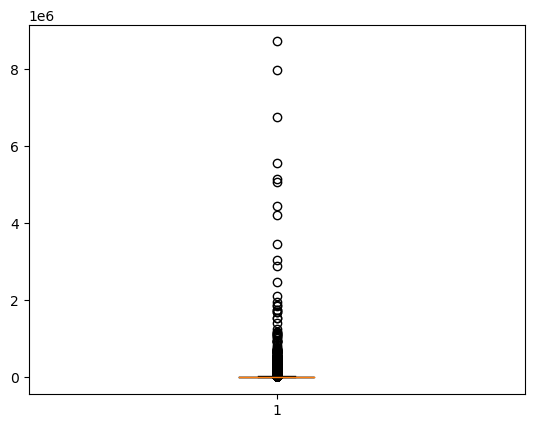

In [146]:
# further evidence to exclude, since the assessed total is much higher than actual residential areas, this could skew results if included.
plt.boxplot(df[df['bldgclass'] == 'V0'].assesstot)
plt.show()

We see there are a lot of outliers, where the vacant land is worth $2M-8M, but majority are under. (where the scientific notation for 1 x 10^6, which is equivalent to 1,000,000)

In [175]:
# Detention house for wayward girls
df[df['bldgclass'] == 'N4'].borough.value_counts()

MN    3
QN    2
BK    1
SI    1
Name: borough, dtype: int64

Text(0, 0.5, 'total value for the tax lot ($)')

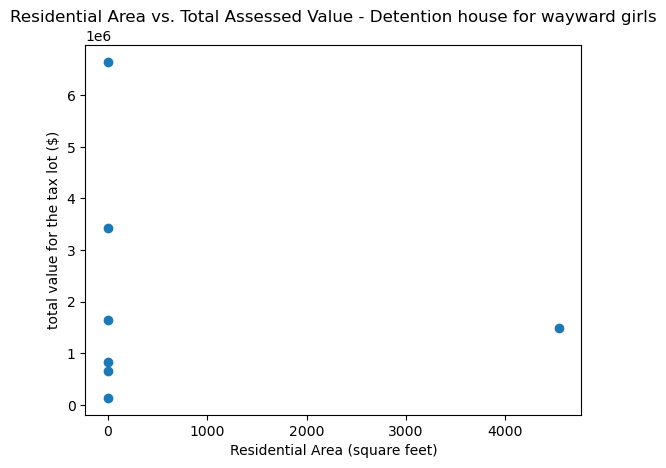

In [260]:
plt.scatter(df[df['bldgclass'] == 'N4'].resarea, df[df['bldgclass'] == 'N4'].assesstot)
plt.title('Residential Area vs. Total Assessed Value - Detention house for wayward girls')
plt.xlabel('Residential Area (square feet)')
plt.ylabel('total value for the tax lot ($)')

Surprising to see the tax value be so high...particularly when the area is very small.

### Assign the Building Classification for Residential

Text(0, 0.5, 'Building Class')

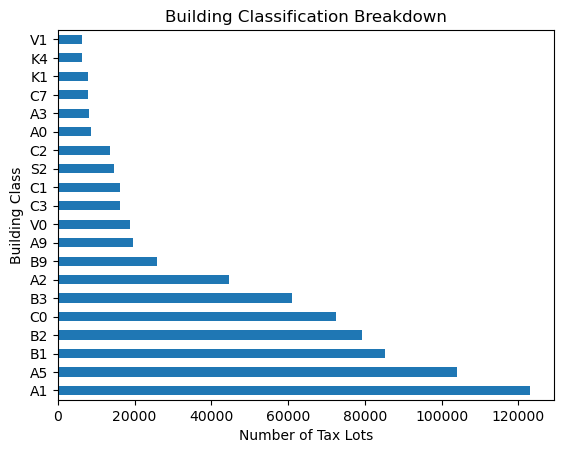

In [112]:
df['bldgclass'].value_counts().head(20).plot(kind="barh")
plt.title('Building Classification Breakdown')
plt.xlabel('Number of Tax Lots')
plt.ylabel('Building Class')

We see the majority are A1, A5 which are one family dwellings. Next we see two family dwellings. Then walk up apartments. It's suprising to see such a large proportion being One and Two family dwellings, I would have expected more apartment dwellings. Perhaps they are aggregated to one tax lot, therefore concentrating the count. Whereas each house would be a separate tax lot. 

Also interesting to see that vacant land that is zoned residential to be one of the highest counts. This seems like opportunity to build more housing.

Used this website to filter to only residential building usage:

https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html

Used best judgement based on understanding of residential usage.

In [172]:
list_output = []
for i in range(1, 4):
    list_output.append(f"L{i}")

In [204]:
list_output

['L1', 'L2', 'L3']

In [121]:
# 	ONE FAMILY DWELLINGS
one_family_dwell = ['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9']

In [124]:
# TWO FAMILY DWELLINGS
two_family_dwell = ['B1', 'B2', 'B3', 'B9']

In [130]:
# WALK UP APARTMENTS
walk_up_apart = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'CM']

In [100]:
# CONDOMINIUMS
residential_condominiums_include = ["R1", "R2", "R3", "R4", "R6", "RR", "R9", "RM", "RX", "RZ", "RR"]

In [101]:
# PRIMARILY RES. - MIXED USE
primarily_res = ["S0", "S1", "S2", "S3", "S4", "S5", "S9"]

In [174]:
# LOFTS
lofts = ['L1', 'L2', 'L3', 'L8', 'L9']

In [169]:
# ELEVATOR APARTMENTS
elevator_apart = ['D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9']

Excluding vacant land, hotels, hospitals and health facilities such as nursing homes and adult care facilities, asylums and orphanages, detention houses. 

Proposed approach: use the residential building class type, if in zoning list we can use an exact match.

In [179]:
all_residential = one_family_dwell + two_family_dwell + walk_up_apart + residential_condominiums_include + primarily_res + lofts + elevator_apart

In [213]:
df[df['bldgclass'].isin(all_residential)].shape[0]

758089

In [214]:
# will be included - majority of dataset (that's my expectation)
(df[df['bldgclass'].isin(all_residential)].shape[0]/len(df))*100

88.29166370648682

In [215]:
# filter to residential only

df_res = df[df['bldgclass'].isin(all_residential)]

# Calculate Price Per Square Foot

(df['assesstot']/(df['resarea']))


assesstot - The assessed total value for the tax lot. The Department of Finance calculates the assessed value by multiplying the tax lot’s
estimated full market value by a uniform percentage for the property’s tax class.

resarea - An estimate of the exterior dimensions of the portion of the structure(s) allocated for
residential use.


The totall tax lot assessment/total residential area for the tax lot

In [283]:
df_res.loc[:, 'ppsqft'] = df_res.assesstot / df_res.resarea
df_res.replace([np.inf, -np.inf], np.nan, inplace=True)

/var/folders/gr/cgd2rmy95vz8fz9vb7t_3ln80000gn/T/ipykernel_38107/911368972.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res.loc[:, 'ppsqft'] = df_res.assesstot / df_res.resarea
/var/folders/gr/cgd2rmy95vz8fz9vb7t_3ln80000gn/T/ipykernel_38107/911368972.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res.replace([np.inf, -np.inf], np.nan, inplace=True)


In [284]:
df_res.head(1)

,borough,block,lot,cd,bct2020,bctcb2020,ct2010,cb2010,schooldist,council,zipcode,firecomp,policeprct,healthcenterdistrict,healtharea,sanitboro,sanitdistrict,sanitsub,address,zonedist1,zonedist2,zonedist3,zonedist4,overlay1,overlay2,spdist1,spdist2,spdist3,ltdheight,splitzone,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,areasource,numbldgs,numfloors,unitsres,unitstotal,lotfront,lotdepth,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,zonemap,zmcode,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes,ppsqft
0,MN,574,65,102.0,1006300.0,1.006300e+10,63.0,2001.0,2.0,3.0,10011.0,E033,6.0,15.0,5700.0,1.0,2.0,3A,41 WEST 10 STREET,R6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,C6,2.0,0.0,NaN,UNAVAILABLE OWNER,2321.0,6540.0,0.0,6540.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,4.0,5.0,5.0,24.5,94.75,25.0,80.0,E,3.0,N,5.0,1.0,567000.0,2223000.0,0.0,1839.0,1989.0,0.0,Greenwich Village Historic District,NaN,2.82,2.43,0.0,4.8,1,1.005740e+09,NaN,63.0,984990.0,206856.0,12c,NaN,103 019,10207.0,NaN,NaN,NaN,1,NaN,NaN,22v3,t,40.734448,-73.99733,NaN,339.908257


In [307]:
df_by_cd = df_res.groupby('cd')[['ppsqft']].agg(avg_ppsqft=('ppsqft','mean'), median_ppsqft=('ppsqft','median'))

In [308]:
df_by_cd.head()

,avg_ppsqft,median_ppsqft
cd,,
101.0,265.072428,210.098942
102.0,286.997269,222.661312
103.0,193.765424,161.615718
104.0,211.883917,166.690146
105.0,274.200015,212.751452


# Shapefiles

Community Districts
GIS data: Boundaries of Community Districts.
All previously released versions of this data are a


https://data.cityofnewyork.us/City-Government/Community-Districts/yfnk-k7r4

In [416]:
cb_shpfile = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/yfnk-k7r4?method=export&format=Shapefile')

In [312]:
cb_shpfile.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [417]:
cb_shpfile.head()

,boro_cd,shape_area,shape_leng,geometry
0,404.0,6.573966e+07,37018.373862,"POLYGON ((-73.84751 40.73901, -73.84801 40.738..."
1,304.0,5.666261e+07,37007.806528,"POLYGON ((-73.89647 40.68234, -73.89653 40.682..."
2,303.0,7.946150e+07,36213.671066,"POLYGON ((-73.91805 40.68721, -73.91800 40.686..."
3,308.0,4.560379e+07,38232.887088,"POLYGON ((-73.95829 40.67983, -73.95596 40.679..."
4,112.0,7.796454e+07,54703.224746,"POLYGON ((-73.93445 40.83598, -73.93464 40.836..."


We can link together using the boro_cd

<AxesSubplot: >

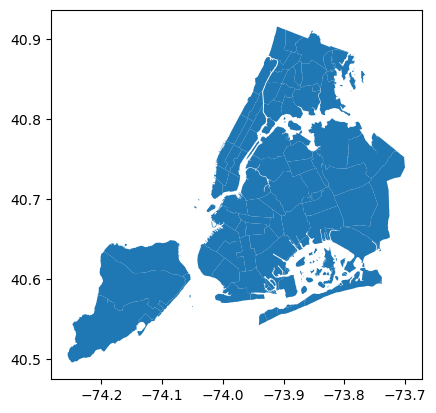

In [201]:
cb_shpfile.plot()

In [415]:
df_by_cd.head()

,avg_ppsqft,median_ppsqft
cd,,
101.0,265.072428,210.098942
102.0,286.997269,222.661312
103.0,193.765424,161.615718
104.0,211.883917,166.690146
105.0,274.200015,212.751452


In [418]:
cb_shpfile = cb_shpfile.merge(df_by_cd, left_on='boro_cd', right_on=df_by_cd.index)

In [419]:
cb_shpfile.head()

,boro_cd,shape_area,shape_leng,geometry,avg_ppsqft,median_ppsqft
0,404.0,6.573966e+07,37018.373862,"POLYGON ((-73.84751 40.73901, -73.84801 40.738...",42.829095,34.556259
1,304.0,5.666261e+07,37007.806528,"POLYGON ((-73.89647 40.68234, -73.89653 40.682...",57.345710,40.966667
2,303.0,7.946150e+07,36213.671066,"POLYGON ((-73.91805 40.68721, -73.91800 40.686...",52.838126,50.625000
3,308.0,4.560379e+07,38232.887088,"POLYGON ((-73.95829 40.67983, -73.95596 40.679...",69.176665,53.500000
4,112.0,7.796454e+07,54703.224746,"POLYGON ((-73.93445 40.83598, -73.93464 40.836...",44.014132,41.063190


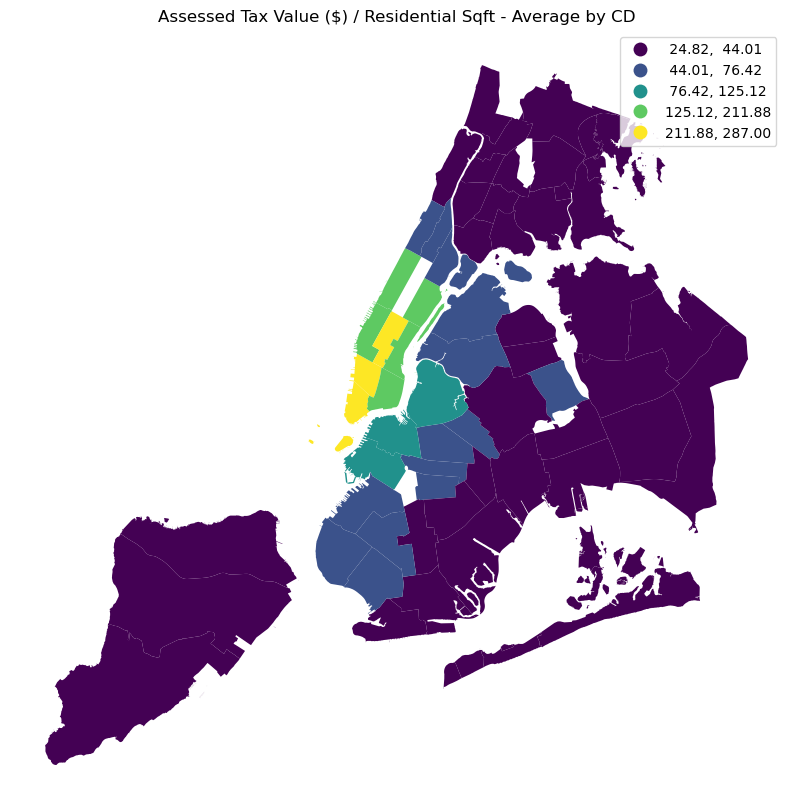

In [420]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cb_shpfile.plot('avg_ppsqft', legend=True, ax=ax, scheme='fisherjenks')
# Set the title and labels
plt.title("Assessed Tax Value ($) / Residential Sqft - Average by CD")
plt.axis('off')

# Show the plot
plt.show()

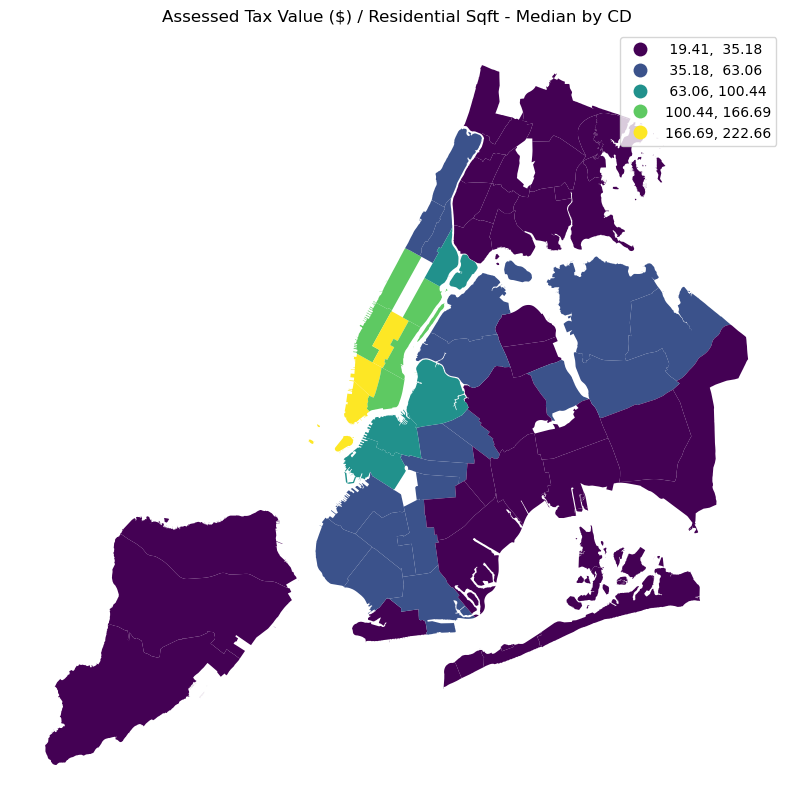

In [311]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
cb_shpfile.plot('median_ppsqft', legend=True, ax=ax, scheme='fisherjenks')
# Set the title and labels
plt.title("Assessed Tax Value ($) / Residential Sqft - Median by CD")
plt.axis('off')

# Show the plot
plt.show()

# Join together all Open Datasets by Community District

In [322]:
data_file_path = '../../../data/odw/open_data/'

In [317]:
affordable_housing_file = 'cleaned_Affordable_Housing_Production_by_cd.csv'
housing_units_file = 'cleaned_housing_units_built_by_community_district.csv'
income_file = 'cleaned_Median_household_income_by_cd.csv'

In [391]:
affordable_housing = pd.read_csv(f'{data_file_path}{affordable_housing_file}')

In [392]:
affordable_housing.rename(columns={'Sum':'affordable_housing_sum'}, inplace=True)

In [393]:
affordable_housing.head()

,Borough,Community district,affordable_housing_sum
0,Bronx,1,4042
1,Bronx,2,3063
2,Bronx,3,4880
3,Bronx,4,5038
4,Bronx,5,3477


In [394]:
# add identifier that can be merged
affordable_housing["cd_name"] = affordable_housing['Borough'] + " Community District " + affordable_housing['Community district'].astype(str) 

In [395]:
cb_info_file = 'cd_administrative.csv'

In [396]:
cb_info = pd.read_csv(f'{data_file_path}{cb_info_file}')

In [397]:
cb_info.head()

,cd_name,cd_number,borough,cd_neighborhoods,cb_email,cb_website,son_issue_1,son_issue_2,son_issue_3
0,Bronx Community District 1,201,Bronx,"Melrose, Mott Haven, Port Morris",brxcb1@optonline.net,www1.nyc.gov/site/bronxcb1/index.page,Affordable housing,Health care services,"Quality of life issues (noise, graffiti, petty..."
1,Bronx Community District 2,202,Bronx,"Hunts Point, Longwood",brxcb2@optonline.net,www.bxcb2.org,Affordable housing,Schools,Traffic
2,Bronx Community District 3,203,Bronx,"Claremont, Crotona Park East, Melrose, Morrisania",brxcomm3@optonline.net,www.nyc.gov/bronxcb3,Health care services,Unemployment,Youth and childrenÕs services
3,Bronx Community District 6,206,Bronx,"Bathgate, Belmont, Bronx Park South, East Trem...",bronxcb6@bronxcb6.org,www.bronxcb6.org,Affordable housing,Economic development and recovery,Schools
4,Bronx Community District 4,204,Bronx,"Concourse, Concourse Village, East Concourse, ...",bx04@cb.nyc.gov,www.nyc.gov/html/bxcb4,Affordable housing,Crime and public safety,"Quality of life issues (noise, graffiti, petty..."


In [398]:
cb_info = cb_info.merge(affordable_housing, on='cd_name')

In [399]:
cb_info.tail()

,cd_name,cd_number,borough,cd_neighborhoods,cb_email,cb_website,son_issue_1,son_issue_2,son_issue_3,Borough,Community district,affordable_housing_sum
54,Queens Community District 13,413,Queens,"Bellaire, Bellerose, Brookville, Cambria Heigh...",info@qcb13.org,www1.nyc.gov/site/queenscb13/index.page,Crime and public safety,Parks and open space,Traffic,Queens,13,74
55,Queens Community District 14,414,Queens,"Arverne, Bayswater, Belle Harbor, Breezy Point...",cbrock14@nyc.rr.com,www1.nyc.gov/site/queenscb14/index.page,Crime and public safety,Infrastructure resiliency,Transit (buses & subways),Queens,14,4086
56,Staten Island Community District 1,501,Staten Island,"Arlington, Castleton Corners, Clifton, Elm Par...",Sicb1@si.rr.com,www1.nyc.gov/site/statenislandcb1/index.page,"Land use trends (zoning, development, neighbor...",Traffic,Transit (buses & subways),Staten Island,1,2016
57,Staten Island Community District 2,502,Staten Island,"Arrochar, Bloomfield, Bulls Head, Chelsea, Con...",dderrico@cb.nyc.gov,www.cb2si.com/,Economic development and recovery,"Land use trends (zoning, development, neighbor...",Traffic,Staten Island,2,390
58,Staten Island Community District 3,503,Staten Island,"Annadale, Arden Heights, Bay Terrace, Butler M...",sicb3@cb.nyc.gov,www1.nyc.gov/site/statenislandcb3/index.page,"Land use trends (zoning, development, neighbor...",Street conditions (roadway maintenance),Traffic,Staten Island,3,50


In [400]:
# double check
cb_info['affordable_housing_sum'].isna().sum()

0

In [401]:
units_housing = pd.read_csv(f'{data_file_path}{housing_units_file}')

In [402]:
units_housing.head()

,commntydst,completedUnits
0,404,2583
1,304,7445
2,303,9430
3,308,5102
4,316,4133


In [403]:
cb_info = cb_info.merge(units_housing, left_on='cd_number', right_on='commntydst')

In [404]:
# double check
cb_info['completedUnits'].isna().sum()

0

In [405]:
income = pd.read_csv(f'{data_file_path}{income_file}', thousands=',') # convert income to int

In [406]:
income.tail()

,GeogName,GeoID,Borough,Median Household Income
54,QN13 Queens Village-Bellerose-Rosedale (CD 13 ...,QN13,Queens,91865
55,QN14 The Rockaways (CD 14 Equivalent),QN14,Queens,59611
56,SI01 North Shore (CD 1 Equivalent),SI01,Staten Island,73974
57,SI02 Mid-Island (CD 2 Approximation),SI02,Staten Island,85629
58,SI03 South Shore (CD 3 Approximation),SI03,Staten Island,100635


In [407]:
# remove the first two letters, then remove leading zero

income['GeoID'] = income['GeoID'].str[2:]
income['GeoID'] = pd.to_numeric(income['GeoID']) # convert to number

In [408]:
# add identifier that can be merged
income["cd_name"] = income['Borough'] + " Community District " + income['GeoID'].astype(str) 

In [409]:
cb_info = cb_info.merge(income, on='cd_name')

In [410]:
cb_info.head()

,cd_name,cd_number,borough,cd_neighborhoods,cb_email,cb_website,son_issue_1,son_issue_2,son_issue_3,Borough_x,Community district,affordable_housing_sum,commntydst,completedUnits,GeogName,GeoID,Borough_y,Median Household Income
0,Bronx Community District 1,201,Bronx,"Melrose, Mott Haven, Port Morris",brxcb1@optonline.net,www1.nyc.gov/site/bronxcb1/index.page,Affordable housing,Health care services,"Quality of life issues (noise, graffiti, petty...",Bronx,1,4042,201,7601,BX01 Melrose-Mott Haven-Port Morris (CD 1 Appr...,1,Bronx,26166
1,Bronx Community District 1,201,Bronx,"Melrose, Mott Haven, Port Morris",brxcb1@optonline.net,www1.nyc.gov/site/bronxcb1/index.page,Affordable housing,Health care services,"Quality of life issues (noise, graffiti, petty...",Bronx,1,4042,201,7601,BX01 Melrose-Mott Haven-Port Morris (CD 1 Appr...,1,Bronx,26166
2,Bronx Community District 2,202,Bronx,"Hunts Point, Longwood",brxcb2@optonline.net,www.bxcb2.org,Affordable housing,Schools,Traffic,Bronx,2,3063,202,2310,BX02 Longwood-Hunts Point (CD 2 Approximation),2,Bronx,29509
3,Bronx Community District 3,203,Bronx,"Claremont, Crotona Park East, Melrose, Morrisania",brxcomm3@optonline.net,www.nyc.gov/bronxcb3,Health care services,Unemployment,Youth and childrenÕs services,Bronx,3,4880,203,7383,BX03 Morrisania-Crotona Park East (CD 3 Approx...,3,Bronx,31359
4,Bronx Community District 6,206,Bronx,"Bathgate, Belmont, Bronx Park South, East Trem...",bronxcb6@bronxcb6.org,www.bronxcb6.org,Affordable housing,Economic development and recovery,Schools,Bronx,6,4775,206,4938,BX06 Tremont-Belmont-West Farms (CD 6 Approxim...,6,Bronx,26473


In [411]:
# double check
cb_info['Median Household Income'].isna().sum()

0

In [412]:
# clean redundant columns

drop_cols = ['Borough_x', 'Community district', 'commntydst', 'GeogName', 'GeoID', 'Borough_y']

In [413]:
cb_info.drop(columns=drop_cols, inplace=True)

In [414]:
cb_info.head()

,cd_name,cd_number,borough,cd_neighborhoods,cb_email,cb_website,son_issue_1,son_issue_2,son_issue_3,affordable_housing_sum,completedUnits,Median Household Income
0,Bronx Community District 1,201,Bronx,"Melrose, Mott Haven, Port Morris",brxcb1@optonline.net,www1.nyc.gov/site/bronxcb1/index.page,Affordable housing,Health care services,"Quality of life issues (noise, graffiti, petty...",4042,7601,26166
1,Bronx Community District 1,201,Bronx,"Melrose, Mott Haven, Port Morris",brxcb1@optonline.net,www1.nyc.gov/site/bronxcb1/index.page,Affordable housing,Health care services,"Quality of life issues (noise, graffiti, petty...",4042,7601,26166
2,Bronx Community District 2,202,Bronx,"Hunts Point, Longwood",brxcb2@optonline.net,www.bxcb2.org,Affordable housing,Schools,Traffic,3063,2310,29509
3,Bronx Community District 3,203,Bronx,"Claremont, Crotona Park East, Melrose, Morrisania",brxcomm3@optonline.net,www.nyc.gov/bronxcb3,Health care services,Unemployment,Youth and childrenÕs services,4880,7383,31359
4,Bronx Community District 6,206,Bronx,"Bathgate, Belmont, Bronx Park South, East Trem...",bronxcb6@bronxcb6.org,www.bronxcb6.org,Affordable housing,Economic development and recovery,Schools,4775,4938,26473


In [423]:
cb_shpfile.head()

,boro_cd,shape_area,shape_leng,geometry,avg_ppsqft,median_ppsqft,cd_name,cd_number,borough,cd_neighborhoods,cb_email,cb_website,son_issue_1,son_issue_2,son_issue_3,affordable_housing_sum,completedUnits,Median Household Income
0,404.0,6.573966e+07,37018.373862,"POLYGON ((-73.84751 40.73901, -73.84801 40.738...",42.829095,34.556259,Queens Community District 4,404,Queens,"Corona, Corona Heights, Elmhurst, Lefrak City",qn04@cb.nyc.gov,www1.nyc.gov/site/queenscb4/index.page,Affordable housing,Schools,Social services,247,2583,55657
1,304.0,5.666261e+07,37007.806528,"POLYGON ((-73.89647 40.68234, -73.89653 40.682...",57.345710,40.966667,Brooklyn Community District 4,304,Brooklyn,Bushwick,BK04@cb.nyc.gov,www.nyc.gov/brooklyncb4,Affordable housing,"Land use trends (zoning, development, neighbor...",Street conditions (roadway maintenance),1224,7445,61436
2,303.0,7.946150e+07,36213.671066,"POLYGON ((-73.91805 40.68721, -73.91800 40.686...",52.838126,50.625000,Brooklyn Community District 3,303,Brooklyn,"Bedford-Stuyvesant, Stuyvesant Heights, Tompki...",bk03@cb.nyc.gov,https://www1.nyc.gov/site/brooklyncb3/index.page,Affordable housing,Schools,Trash removal & cleanliness,2419,9430,63177
3,308.0,4.560379e+07,38232.887088,"POLYGON ((-73.95829 40.67983, -73.95596 40.679...",69.176665,53.500000,Brooklyn Community District 8,308,Brooklyn,"Crown Heights, Prospect Heights, Weeksville",brooklynCB8@gmail.com,www.brooklyncb8.org,Affordable housing,Infrastructure resiliency,Parks and open space,2083,5102,67479
4,112.0,7.796454e+07,54703.224746,"POLYGON ((-73.93445 40.83598, -73.93464 40.836...",44.014132,41.063190,Manhattan Community District 12,112,Manhattan,"Inwood, Washington Heights",ebsmith@cb.nyc.gov,www.nyc.gov/html/mancb12,Affordable housing,"Land use trends (zoning, development, neighbor...",Schools,1594,670,59257


In [422]:
# merge with shapefile and the price per square foot

cb_shpfile = cb_shpfile.merge(cb_info, left_on='boro_cd', right_on='cd_number')

In [424]:
cb_shpfile.isna().sum()

boro_cd                    0
shape_area                 0
shape_leng                 0
geometry                   0
avg_ppsqft                 0
median_ppsqft              0
cd_name                    0
cd_number                  0
borough                    0
cd_neighborhoods           0
cb_email                   0
cb_website                 0
son_issue_1                0
son_issue_2                0
son_issue_3                0
affordable_housing_sum     0
completedUnits             0
Median Household Income    0
dtype: int64

In [429]:
# export

cb_shpfile.to_file(filename=f'{data_file_path}open_data_by_cd.shp.zip', driver='ESRI Shapefile')

/var/folders/gr/cgd2rmy95vz8fz9vb7t_3ln80000gn/T/ipykernel_38107/892951328.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  cb_shpfile.to_file(filename=f'{data_file_path}open_data_by_cd.shp.zip', driver='ESRI Shapefile')


In [430]:
test = gpd.read_file(f'{data_file_path}open_data_by_cd.shp')

In [431]:
test.head()

,boro_cd,shape_area,shape_leng,avg_ppsqft,median_pps,cd_name,cd_number,borough,cd_neighbo,cb_email,cb_website,son_issue_,son_issu_1,son_issu_2,affordable,completedU,Median Hou,geometry
0,404.0,6.573966e+07,37018.373862,42.829095,34.556259,Queens Community District 4,404,Queens,"Corona, Corona Heights, Elmhurst, Lefrak City",qn04@cb.nyc.gov,www1.nyc.gov/site/queenscb4/index.page,Affordable housing,Schools,Social services,247,2583,55657,"POLYGON ((-73.84751 40.73901, -73.84801 40.738..."
1,304.0,5.666261e+07,37007.806528,57.345710,40.966667,Brooklyn Community District 4,304,Brooklyn,Bushwick,BK04@cb.nyc.gov,www.nyc.gov/brooklyncb4,Affordable housing,"Land use trends (zoning, development, neighbor...",Street conditions (roadway maintenance),1224,7445,61436,"POLYGON ((-73.89647 40.68234, -73.89653 40.682..."
2,303.0,7.946150e+07,36213.671066,52.838126,50.625000,Brooklyn Community District 3,303,Brooklyn,"Bedford-Stuyvesant, Stuyvesant Heights, Tompki...",bk03@cb.nyc.gov,https://www1.nyc.gov/site/brooklyncb3/index.page,Affordable housing,Schools,Trash removal & cleanliness,2419,9430,63177,"POLYGON ((-73.91805 40.68721, -73.91800 40.686..."
3,308.0,4.560379e+07,38232.887088,69.176665,53.500000,Brooklyn Community District 8,308,Brooklyn,"Crown Heights, Prospect Heights, Weeksville",brooklynCB8@gmail.com,www.brooklyncb8.org,Affordable housing,Infrastructure resiliency,Parks and open space,2083,5102,67479,"POLYGON ((-73.95829 40.67983, -73.95596 40.679..."
4,112.0,7.796454e+07,54703.224746,44.014132,41.063190,Manhattan Community District 12,112,Manhattan,"Inwood, Washington Heights",ebsmith@cb.nyc.gov,www.nyc.gov/html/mancb12,Affordable housing,"Land use trends (zoning, development, neighbor...",Schools,1594,670,59257,"POLYGON ((-73.93445 40.83598, -73.93464 40.836..."


In [437]:
cb_shpfile.head()

,boro_cd,shape_area,shape_leng,geometry,avg_ppsqft,median_ppsqft,cd_name,cd_number,borough,cd_neighborhoods,cb_email,cb_website,son_issue_1,son_issue_2,son_issue_3,affordable_housing_sum,completedUnits,Median Household Income
0,404.0,6.573966e+07,37018.373862,"POLYGON ((-73.84751 40.73901, -73.84801 40.738...",42.829095,34.556259,Queens Community District 4,404,Queens,"Corona, Corona Heights, Elmhurst, Lefrak City",qn04@cb.nyc.gov,www1.nyc.gov/site/queenscb4/index.page,Affordable housing,Schools,Social services,247,2583,55657
1,304.0,5.666261e+07,37007.806528,"POLYGON ((-73.89647 40.68234, -73.89653 40.682...",57.345710,40.966667,Brooklyn Community District 4,304,Brooklyn,Bushwick,BK04@cb.nyc.gov,www.nyc.gov/brooklyncb4,Affordable housing,"Land use trends (zoning, development, neighbor...",Street conditions (roadway maintenance),1224,7445,61436
2,303.0,7.946150e+07,36213.671066,"POLYGON ((-73.91805 40.68721, -73.91800 40.686...",52.838126,50.625000,Brooklyn Community District 3,303,Brooklyn,"Bedford-Stuyvesant, Stuyvesant Heights, Tompki...",bk03@cb.nyc.gov,https://www1.nyc.gov/site/brooklyncb3/index.page,Affordable housing,Schools,Trash removal & cleanliness,2419,9430,63177
3,308.0,4.560379e+07,38232.887088,"POLYGON ((-73.95829 40.67983, -73.95596 40.679...",69.176665,53.500000,Brooklyn Community District 8,308,Brooklyn,"Crown Heights, Prospect Heights, Weeksville",brooklynCB8@gmail.com,www.brooklyncb8.org,Affordable housing,Infrastructure resiliency,Parks and open space,2083,5102,67479
4,112.0,7.796454e+07,54703.224746,"POLYGON ((-73.93445 40.83598, -73.93464 40.836...",44.014132,41.063190,Manhattan Community District 12,112,Manhattan,"Inwood, Washington Heights",ebsmith@cb.nyc.gov,www.nyc.gov/html/mancb12,Affordable housing,"Land use trends (zoning, development, neighbor...",Schools,1594,670,59257


In [447]:
# visualize each
def plot_column(col_name):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    test.plot(col_name, legend=True, ax=ax, scheme='fisherjenks')
    # Set the title and labels
    plt.title(f"{col_name} by CD")
    plt.axis('off')

    # Show the plot
    plt.show()

In [448]:
cols = ['affordable', 'completedU', 'Median Hou']

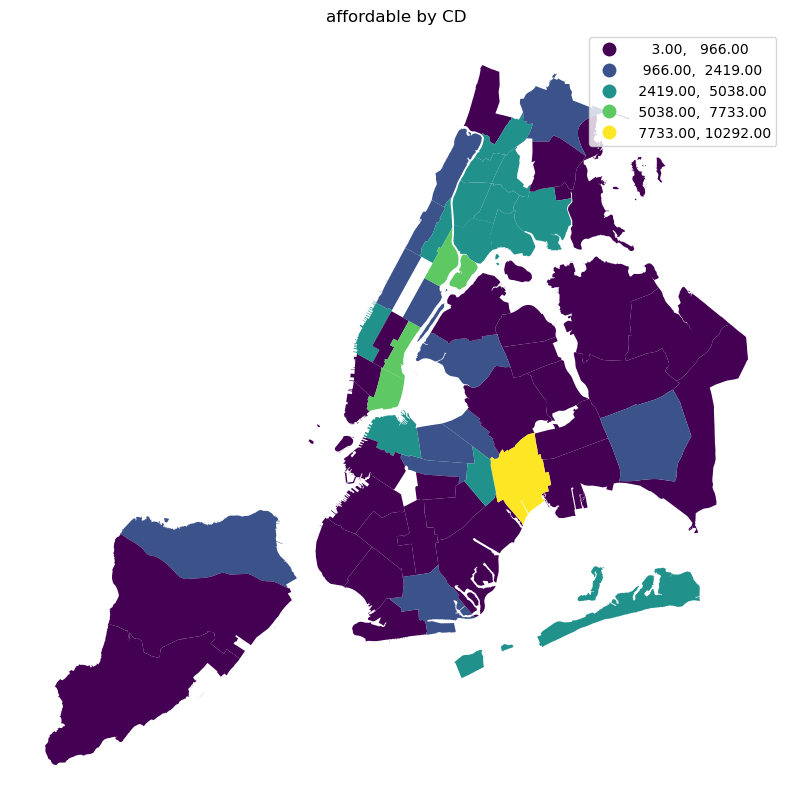

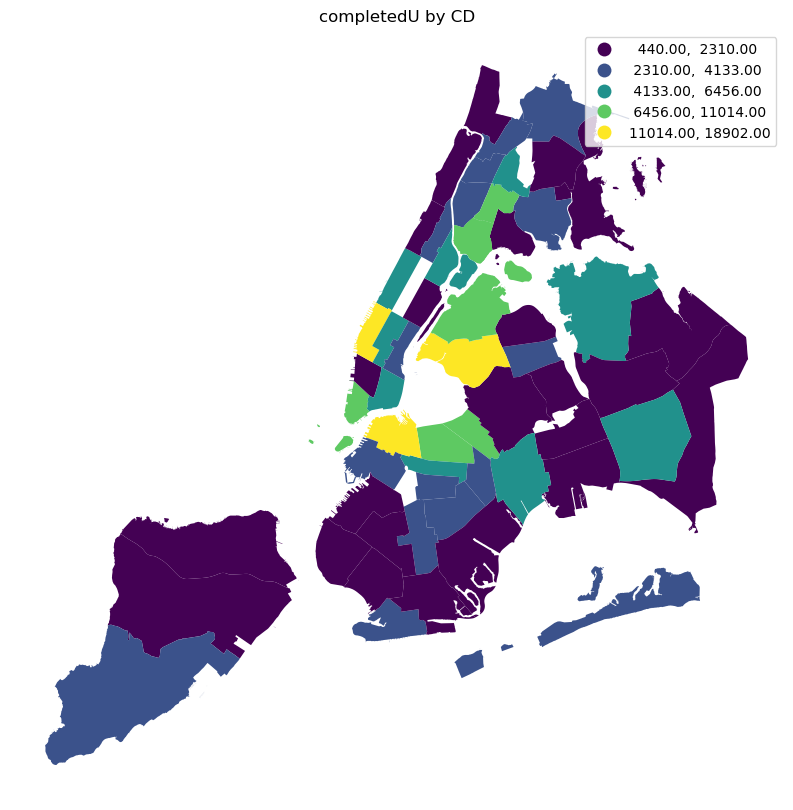

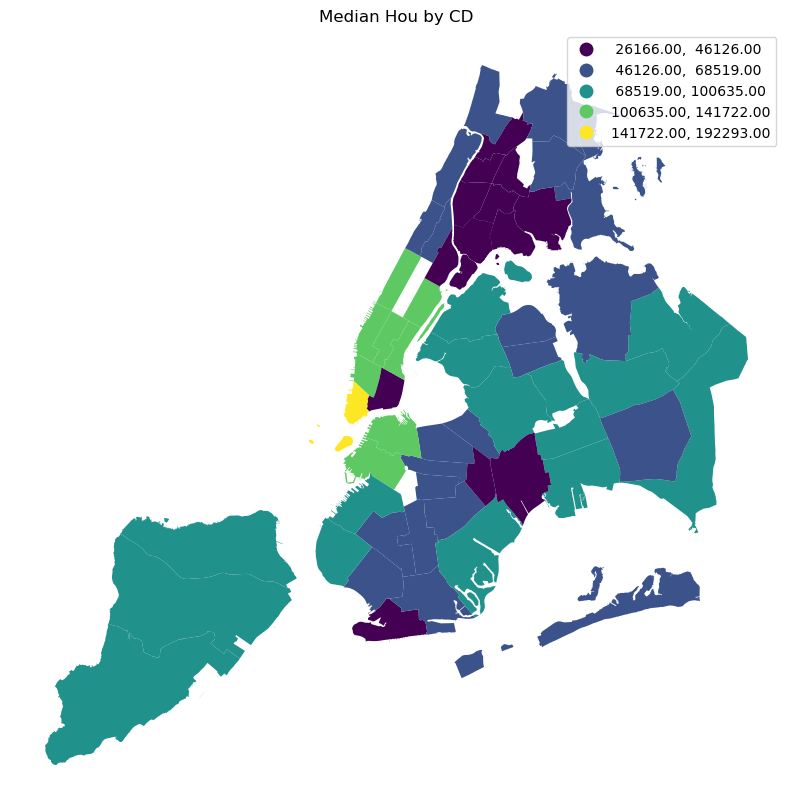

In [449]:
for i in cols:
    plot_column(i)

# Review to provide base truth

Conclusion is that we will be approximating the tax value which will be much lower than the demand value.

In [225]:
df[df['address'].str.contains('57TH STREET', na=False)].head()

,borough,block,lot,cd,bct2020,bctcb2020,ct2010,cb2010,schooldist,council,zipcode,firecomp,policeprct,healthcenterdistrict,healtharea,sanitboro,sanitdistrict,sanitsub,address,zonedist1,zonedist2,zonedist3,zonedist4,overlay1,overlay2,spdist1,spdist2,spdist3,ltdheight,splitzone,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,areasource,numbldgs,numfloors,unitsres,unitstotal,lotfront,lotdepth,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,zonemap,zmcode,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
192842,BK,5693,7504,312.0,3010402.0,3.010402e+10,104.0,1001.0,20.0,38.0,11220.0,L114,66.0,39.0,6700.0,3.0,12.0,1C,850 57TH STREET,R6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,RM,4.0,0.0,NaN,WINLE PROPERTY LLC,2003.0,5872.0,2541.0,3331.0,0.0,2541.0,0.0,0.0,0.0,0.0,2.0,1.0,4.25,5.0,7.0,20.00,100.17,20.00,85.0,NaN,3.0,N,0.0,5.0,72001.0,450451.0,0.0,1920.0,0.0,0.0,NaN,NaN,2.93,2.43,0.0,4.8,3,3.056938e+09,4985.0,104.0,982391.0,171081.0,22a,NaN,306A033,31708.0,NaN,NaN,NaN,1,NaN,NaN,22v3,NaN,40.636254,-74.006698,NaN
290480,BK,848,7502,307.0,3010200.0,3.010200e+10,102.0,3001.0,20.0,38.0,11220.0,L114,72.0,31.0,7700.0,3.0,7.0,4D,540 57TH STREET,R6B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,R1,2.0,0.0,NaN,NA HAO LLC,2003.0,4219.0,0.0,4219.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,4.00,6.0,6.0,20.00,100.17,20.00,65.0,NaN,3.0,N,0.0,5.0,72001.0,275850.0,262738.0,2013.0,0.0,0.0,NaN,NaN,2.11,2.00,0.0,2.0,3,3.008488e+09,4298.0,102.0,980495.0,172585.0,22a,NaN,306A025,30308.0,NaN,NaN,NaN,1,NaN,NaN,22v3,NaN,40.640382,-74.013530,NaN
304314,BK,5500,7506,312.0,3046800.0,3.046800e+10,468.0,1004.0,21.0,44.0,11204.0,E330,66.0,31.0,8110.0,3.0,12.0,4C,2070 57TH STREET,R5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,R6,2.0,0.0,NaN,2074 57 DEVELOPMENT LLC,2266.0,5290.0,0.0,5290.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3.00,3.0,3.0,0.00,0.00,22.67,65.0,NaN,0.0,N,0.0,5.0,36060.0,175801.0,0.0,2017.0,0.0,0.0,NaN,NaN,2.33,1.25,0.0,2.0,3,3.055008e+09,4240.0,468.0,989929.0,165106.0,22d,NaN,310A023,31703.0,NaN,NaN,NaN,1,NaN,NaN,22v3,NaN,40.619852,-73.979544,NaN
442910,BK,5500,7505,312.0,3046800.0,3.046800e+10,468.0,1004.0,21.0,44.0,11204.0,E330,66.0,31.0,8110.0,3.0,12.0,4C,2074 57TH STREET,R5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,R6,2.0,0.0,NaN,2074 57 DEVELOPMENT LLC,2732.0,5653.0,0.0,5653.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,3.00,3.0,3.0,27.33,100.17,23.33,65.0,NaN,0.0,N,0.0,5.0,43440.0,187740.0,0.0,2017.0,0.0,0.0,NaN,NaN,2.07,1.25,0.0,2.0,3,3.055008e+09,4241.0,468.0,989948.0,165091.0,22d,NaN,310A023,31703.0,NaN,NaN,NaN,1,NaN,NaN,22v3,NaN,40.619811,-73.979475,NaN
451601,MN,1029,7502,105.0,1013700.0,1.013700e+10,137.0,4003.0,2.0,4.0,10019.0,E023,18.0,15.0,4700.0,1.0,5.0,2A,217 WEST 57TH STREET,C5-3,C5-1,NaN,NaN,NaN,NaN,MiD,NaN,NaN,NaN,Y,RM,4.0,0.0,NaN,"BROADWAY 57TH/58TH RETAIL INVESTOR, LLC",55861.0,594496.0,284119.0,594496.0,0.0,284119.0,0.0,0.0,0.0,0.0,2.0,1.0,98.00,176.0,180.0,150.00,200.84,0.00,0.0,NaN,0.0,N,0.0,5.0,14467512.0,203954423.0,0.0,2013.0,0.0,0.0,NaN,INDIVIDUAL LANDMARK,10.64,10.00,15.0,15.0,1,1.010298e+09,2967.0,137.0,989454.0,218588.0,8c,NaN,106W030,10402.0,NaN,NaN,NaN,1,NaN,NaN,22v3,NaN,40.766648,-73.981213,NaN


In [227]:
df['block'].value_counts().head()

2925    577
7405    539
4452    536
7422    485
869     412
Name: block, dtype: int64

Interesting idiosyncracy in PLUTO - I tried finding my building and couldn't find a match...likely due to the following information:

https://s-media.nyc.gov/agencies/dcp/assets/files/pdf/data-tools/bytes/PlutoReadme.pdf?r=22v3

The PLUTO data contain one record per tax lot **except for condominiums**. 

PLUTO data contain one record per condominium complex instead of records for each condominium unit tax lot. A tax lot is usually a parcel of real property. The parcel can be under water, vacant, or contain one or more buildings or
structures. The Department of Finance assigns a tax lot number to each condominium unit and
a "billing" tax lot number to the Condominium Complex. 

A Condominium Complex is defined as one or more structures or properties under the auspices of the same condominium association.
DCP summarizes DOF's condominium unit tax lot data so that each Condominium Complex
within a tax block is represented by only one record. The Condominium Complex record is
assigned the "billing" tax lot number when one exists. When the "billing" tax lot number has not
yet been assigned by DOF, the lowest tax lot number within the tax block of the Condominium
Complex is assigned.

---- 
So this is why condominiums don't represent the same count rate. But still represent all tax lots in NYC. 

In [252]:
# where I assume majority of density in NYC is living
df_res[(df_res['bldgclass'].isin(residential_condominiums_include)) | (df_res['bldgclass'].isin(elevator_apart))].borough.value_counts()

MN    8773
BK    8655
QN    3392
BX    3105
SI     272
Name: borough, dtype: int64

In [255]:
# outliers, low count
df_res[df_res.unitsres == 0].shape

(5, 92)

In [254]:
df_res.unitsres.describe()

count    758087.000000
mean          4.767495
std          42.456346
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max       19201.000000
Name: unitsres, dtype: float64

We see that most tax lots have an average of 5 residential units. Compared to the apartment and condominiums that average 73 residential units. Let's see if the tax valuation takes into account the density of people, or do we need to multiply the tax value by # of units?


From PLUTO data dictionary, we see the following information:

For condominiums, RESIDENTIAL FLOOR AREA is the sum of the residential floor
area for condominium lots with the same billing lot. RESIDENTIAL FLOOR AREA
does not contain the condominium’s common area.

In [257]:
dense_lots = df_res[(df_res['bldgclass'].isin(residential_condominiums_include)) | (df_res['bldgclass'].isin(elevator_apart))]

In [258]:
dense_lots.unitsres.describe()

count    24195.000000
mean        72.597148
std        224.895941
min          0.000000
25%         11.000000
50%         38.000000
75%         73.000000
max      19201.000000
Name: unitsres, dtype: float64

Text(0, 0.5, 'total value for the tax lot ($)')

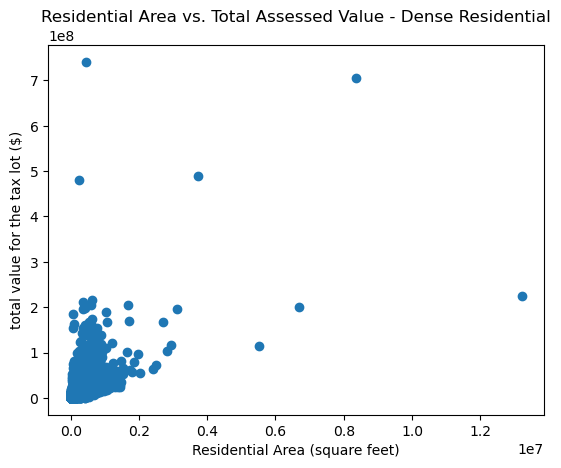

In [264]:
plt.scatter(dense_lots.resarea, dense_lots.assesstot)
plt.title('Residential Area vs. Total Assessed Value - Dense Residential')
plt.xlabel('Residential Area (square feet)')
plt.ylabel('total value for the tax lot ($)')

Interesting to see that most High Density tax lots are concentrated into similar total area and total value, curious where the outliers exists. But this confirms assumption that calculating price per square foot of tax lot would account for high density.

In [265]:
dense_lots.loc[:, 'ppsqft'] = dense_lots.assesstot / dense_lots.resarea

/var/folders/gr/cgd2rmy95vz8fz9vb7t_3ln80000gn/T/ipykernel_38107/2394959498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dense_lots.loc[:, 'ppsqft'] = dense_lots.assesstot / dense_lots.resarea


In [268]:
dense_lots.replace([np.inf, -np.inf], np.nan, inplace=True)

/var/folders/gr/cgd2rmy95vz8fz9vb7t_3ln80000gn/T/ipykernel_38107/112920351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dense_lots.replace([np.inf, -np.inf], np.nan, inplace=True)


Wow the price per square foot will be a lot lower than what is listed online. For example the lot in 340 Cabrini is $70 ppsqft when online it's listed at $811

Great example of how the taxable value is shared on the website, and is much lower than the price per square foot.

https://www.compass.com/listing/340-cabrini-boulevard-unit-201-manhattan-ny-10040/1164468514558589297/

One unit in this aparment has $81,658 in assesstot, for 1,220 sqft


In [276]:
# this is much closer to the ppsqft we would be - we see this is close to the ppsqft for this tax lot, assuming each other unit is similar.
81658/1220

66.9327868852459

https://www.propertyshark.com/mason/Property/133214690/430-Broome-St-New-York-NY-10013/

Notice this is the same exact block & lot. We see example that has mixed use of residential and commercial area. 

Makes sense that residential area would be ~4 x lot area since apartment would be stacked on top.

If we take the total residential area and use the total assess value, we would be adding in the valuation from comercial and all other areas...what if we subtract different calculations?

So the issue is that the tax lot value will include valuation from commercial area in addition to residential in the total, and if we divide a larger value by a smaller number then our estimate will be lower.


The Department of Finance calculates the assessed value by multiplying the tax lot’s
estimated full market value by a uniform percentage for the property’s tax class. 

However because of the above, it uses the tax class or building class uniformly so we may recieve the appropriate value.



In [280]:
dense_lots[dense_lots['address']=='430 BROOME STREET']['lotarea']*4

22    8916.0
Name: lotarea, dtype: float64

In [279]:
dense_lots[dense_lots['address']=='430 BROOME STREET']

,borough,block,lot,cd,bct2020,bctcb2020,ct2010,cb2010,schooldist,council,zipcode,firecomp,policeprct,healthcenterdistrict,healtharea,sanitboro,sanitdistrict,sanitsub,address,zonedist1,zonedist2,zonedist3,zonedist4,overlay1,overlay2,spdist1,spdist2,spdist3,ltdheight,splitzone,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,areasource,numbldgs,numfloors,unitsres,unitstotal,lotfront,lotdepth,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,zonemap,zmcode,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes,ppsqft
22,MN,482,7503,102.0,1004500.0,1.004500e+10,45.0,1001.0,2.0,1.0,10013.0,E055,5.0,15.0,6800.0,1.0,2.0,1A,430 BROOME STREET,M1-5/R7D,NaN,NaN,NaN,NaN,NaN,SNX,NaN,NaN,NaN,N,RM,4.0,0.0,NaN,UNAVAILABLE OWNER,2229.0,10822.0,3151.0,7671.0,0.0,3151.0,0.0,0.0,0.0,0.0,2.0,1.0,NaN,4.0,5.0,0.0,0.0,25.0,85.0,NaN,3.0,N,0.0,2.0,251098.0,2752648.0,0.0,1895.0,1988.0,0.0,SoHo-Cast Iron Historic District Extension,NaN,4.86,0.0,5.0,6.5,1,1.004828e+09,2387.0,45.0,984590.0,202156.0,12c,NaN,11N 073,10206.0,NaN,1.004820e+09,04/17/2014,1,NaN,NaN,22v3,t,40.721548,-73.998773,NaN,358.838222


In [278]:
dense_lots.head()[['borough','address','assesstot', 'resarea','residfar', 'unitsres', 'ppsqft']]

,borough,address,assesstot,resarea,residfar,unitsres,ppsqft
6,BK,175 SPENCER STREET,2405206.0,26041.0,2.00,35.0,92.362275
21,MN,472 AVENUE OF THE AMER,5186700.0,28903.0,6.02,41.0,179.451960
22,MN,430 BROOME STREET,2752648.0,7671.0,0.00,4.0,358.838222
33,MN,340 CABRINI BOULEVARD,1391671.0,19770.0,3.44,20.0,70.393070
35,BK,159 BAY 32 STREET,246719.0,7356.0,1.25,6.0,33.539831


<AxesSubplot: >

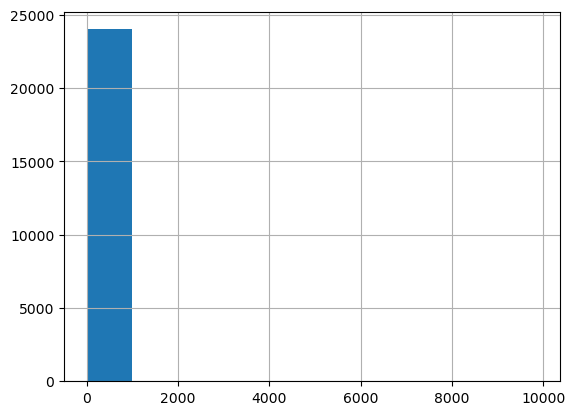

In [269]:
dense_lots['ppsqft'].hist()

In [250]:
# surprising the value isn't higher
df[df['bldgclass']== ('RM')].borough.value_counts() == df_res[df_res['bldgclass']== ('RM')].borough.value_counts()

MN    True
BK    True
QN    True
BX    True
SI    True
Name: borough, dtype: bool

<AxesSubplot: >

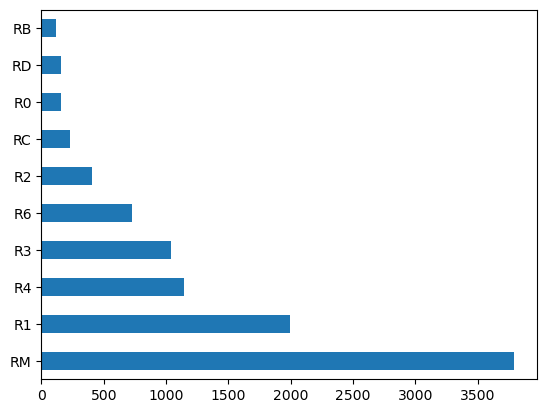

In [248]:
# 
df[df['bldgclass'].str.contains('R', na=False)].bldgclass.value_counts().head(10).plot(kind="barh")

If the unit lots are a mixture of commercial and residential building types,
BUILDING CLASS = RM.

Largest is mixed use 

## Experimentation to Review Approaches to Calculate

From ChatGPT:

It is possible for a property in the NYC PLUTO dataset to have a non-zero value for the resarea column and a zero value for the `unitsres` column, even if the zoning category does not start with R. This is because the resarea column represents the total area of the property that is used for residential purposes, while the unitsres column represents the number of residential units on the property.

It's possible that a property that is zoned for commercial or industrial use but has a small portion of it set aside for residential use and therefore could have non-zero resarea. Or that a property that is zoned for residential use but has no residential units, for example, it could be a multi-unit building that has been converted to office space or a empty land that is zoned for residential use but no construction has been done yet.

It's important to note that the PLUTO dataset is a collection of property characteristics, but it's not a definitive guide to a property's use. It's a good idea to cross-reference with other datasets and do further research if you are unsure about a particular property's use.

In [53]:
test = df[df['address'] == '1224 DECATUR STREET']

Sqrft has been consistently correct, the assess total has high variance vs. what is online. 

Assumed each will be the total price per sqrft for the entire property, not necessarily broken down by unit. (per unit the price will go up in order to make profit is assumption)

Outcome: the numbers in legend likely won't reflect the actual price per square foot based on demand valuation, it's more based on tax property value which may not have increased demand. 

But it's the only open data available in format that is accessible.

In [56]:
test

,borough,block,lot,cd,bct2020,bctcb2020,ct2010,cb2010,schooldist,council,zipcode,firecomp,policeprct,healthcenterdistrict,healtharea,sanitboro,sanitdistrict,sanitsub,address,zonedist1,zonedist2,zonedist3,zonedist4,overlay1,overlay2,spdist1,spdist2,spdist3,ltdheight,splitzone,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,areasource,numbldgs,numfloors,unitsres,unitstotal,lotfront,lotdepth,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,zonemap,zmcode,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
858618,BK,3435,25,304.0,3041100.0,3.041100e+10,411.0,1000.0,32.0,37.0,11207.0,Q252,83.0,34.0,3500.0,3.0,4.0,3B,1224 DECATUR STREET,R6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,B2,1.0,0.0,NaN,DECATUR GOLD LLC,1849.0,2775.0,0.0,1850.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2.0,2.0,18.5,100.0,18.5,50.0,N,3.0,N,5.0,1.0,11520.0,68160.0,0.0,1899.0,0.0,0.0,NaN,NaN,1.5,2.43,0.0,4.8,3,3.034350e+09,NaN,411.0,1010128.0,190416.0,17c,NaN,309 021,31109.0,NaN,NaN,NaN,1,NaN,NaN,22v3,NaN,40.689287,-73.906687,NaN


Seems like assesstot is very different than what is posted on Zillow which is probably more reflective of actual prices. Seems to underestimate.

In [55]:
test[['assesstot', 'resarea', 'unitsres']]

,assesstot,resarea,unitsres
858618,68160.0,1850.0,2.0


Based on spot check, there seems to be high variance between assesstot vs. what is listed online. 

In [40]:
# this example has a much lower assesstotal than what is listed online...
df[df['address'] == '177 COOPER STREET'][['assesstot', 'resarea', 'unitsres']]

,assesstot,resarea,unitsres
1,74940.0,1800.0,2.0


I assume resarea is for all the total residential floors in the building. Since just one unit in example was listed at 800 sqft. If we divide resarea by number of units we see a area per unit that's greater than what was listed.

In [37]:
df[df['address'] == '41 WEST 10 STREET'][['assesstot', 'resarea', 'unitsres']]

,assesstot,resarea,unitsres
0,2223000.0,6540.0,5.0


In [51]:
2223000.0/6540.0

339.908256880734

In [42]:
707000/1800

392.77777777777777

In [44]:
test = df[df['address'] == '177 COOPER STREET']

In [46]:
test['assesstot']

1    74940.0
Name: assesstot, dtype: float64

In [50]:
# likely a better estimate for each unit in the residential property - seems to have variance vs. online
(test['assesstot']/(test['resarea']))

1    41.633333
dtype: float64

In [18]:
test = df.head()

In [34]:
# likely a better estimate for each unit in the residential property
(test['resarea']/test['unitsres'])

0    1308.0
1     900.0
2    1100.0
3    1710.0
4       NaN
dtype: float64

In [36]:
test['assesstot'] / (test['resarea'])

0    339.908257
1     41.633333
2     34.445455
3     20.210526
4           inf
dtype: float64

In [35]:
test['assesstot'] / (test['resarea']/test['unitsres'])

0    1699.541284
1      83.266667
2      68.890909
3      20.210526
4            NaN
dtype: float64

Seems like only one unit within this record has following ppsqft

https://streeteasy.com/building/41-west-10-street-new_york/1

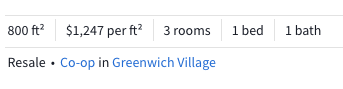

Spot check: 

Seems like PLUTO aggregates for the entire property, rather than an individual apartments sqft. 

For this location

For 41 WEST 10 STREET the ppsqft is $339.908257 but this underestimates the unit difference. When we divide by number of units available we get closer value of: $1699.541284

Square feet: 6,540

What is the assessed value of 41 West 10th Street, New York, NY 10011 and the property tax paid?
Assessed at $2,223,000, the tax amount paid for 41 West 10th Street, New York, NY 10011 is $77,001.

https://www.propertyshark.com/mason/Property/7610/41-W-10-St-New-York-NY-10011/


### Q&A from ChatGPT

**Why do you think the AssessTot column varies so much compared to the estimated value found online from websites like Zillow?**

There are several reasons why the AssessTot column in the PLUTO dataset might vary significantly compared to the estimated value found online from websites like Zillow:
Timing: The PLUTO dataset is updated periodically, while online estimates are available in real-time. Assessed values in the PLUTO dataset may not reflect the current market value of a property.
Valuation methodologies: Zillow and other online real estate websites use proprietary algorithms to estimate property values, which may not be directly comparable to the assessed values in the PLUTO dataset. These algorithms may consider factors such as recent sales data, neighborhood characteristics, and public records, but not all of these factors are considered in the assessment process.
Data quality: The PLUTO dataset may contain errors or missing values that affect the accuracy of the assessed values. Additionally, Zillow uses additional data sources (such as MLS data, public records, and user-submitted data) which can be more accurate than the data found in the PLUTO dataset.
Assessed values are used for tax purposes, they are not the same as market value, they are used to calculate property taxes. Assessed values may be lower than market value.
It's important to understand that the Assessed Total Value (AssessTot) in the PLUTO dataset is not the same as the market value of a property, it's a value used to calculate property taxes. The AssessTot value is determined by the NYC Department of Finance and it is based on a property's characteristics and location. Websites like Zillow, Redfin, and other online real estate platforms provide estimated market value of a property, which is based on a variety of factors, including recent sales data, neighborhood characteristics, and public records.